# Example for DSAFT model (based on CoxPH from PyCox)

In this notebook we will show how to train and get computed evaluation metric from model, based on [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf) provided by [PyCox](https://github.com/havakv/pycox) package.
We will use the METABRIC data sets as an example

※ Evaluation metric depends on [Lifelines](https://lifelines.readthedocs.io/en/latest/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import Tensor
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
import wandb

In [3]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [5]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [6]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [7]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [9]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [10]:
x_train.shape

(1218, 9)

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

wandb.init(project="dsaft", 
           group="dsaft",
           name="hyperparametersearch",
           config={
    "dropout":0.2,
    'batch_norm':True,
})

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

wandb: Currently logged in as: wnsgus33 (use `wandb login --relogin` to force relogin)


## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

#### DSAFT Loss

Loss functions for Deep Semi-parametric AFT (DSAFT) models are different from that of CoxPH. However, application is simple that only change of loss function is needed after instantiating PyCox model.

In [12]:
# set DSAFT Loss
# (RMSE-type loss in this example)

def dsaft_rmse_loss(theta, durations, events):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    # compute residual e_i
    e = theta.sub(durations.view(-1, 1).add(1e-32).log()).neg()
    
    # sort e_i w.r.t values and store sorted indices
    e_sorted = torch.sort(e.view(-1)).values
    e_indices = torch.sort(e.view(-1)).indices.type(torch.float32)
    
    # sort durations(log(Y)), events(delta), and theta(output from DNN) w.r.t. sorted indices of e_i
    tmp = torch.stack([e_indices, durations.view(-1), events.type(torch.float32).view(-1), theta.view(-1)], dim = 1)
    tmp = tmp[tmp[:, 0].sort()[1]]
    durations_sorted = tmp[:, 1]
    events_sorted = tmp[:, 2]
    theta_sorted = tmp[:, 3]
    
    # get risk set and removed (instances whose events had been occured)
    at_risks = (e_sorted.view(-1, 1).sub(e_sorted) <= 0).mul(1)
    removed = (e_sorted.view(-1, 1).sub(e_sorted) > 0).mul(1)
    
    # estimate survival function of e_i via KM estimator
    surv = events_sorted.div(at_risks.sum(1)).sub(1).neg().abs().mul(removed).add(at_risks).prod(dim = 1)
    
    # estimate differential of F (cumulative density function) i.e. dF(u)
    d_cdf = torch.cat([surv.sub(1).abs()[1:], torch.ones(1).to(surv.device)]).sub(surv.sub(1).abs())
    
    # evaluate conditional expectation of epsilon
    cond_E = e_sorted.mul(d_cdf).mul(at_risks).sum(dim = 1).mul(surv.reciprocal()).add(theta_sorted)
    
    # evaluate y_hat: imputed y
    imputed = events_sorted.mul(durations_sorted.add(1e-32).log().sub(cond_E)).add(cond_E)
    
    # takes MAE form rather than MSE for practically stable convergence
    loss = imputed.sub(theta_sorted).pow(2).sum().mul(1 / e_sorted.shape[0]).pow(0.5)
    wandb.log({'loss':loss})
    
    return loss

class DSAFTRMSELoss(torch.nn.Module):
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor) -> Tensor:
        return dsaft_rmse_loss(log_h, durations, events)

In [13]:
model = CoxPH(net, tt.optim.Adam)
wandb.watch(net)

/home/junhyun/miniconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
model.loss = DSAFTRMSELoss()

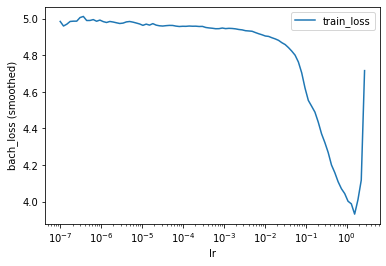

In [15]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [16]:
best = lrfinder.get_best_lr()

In [17]:
best

0.15556761439304817

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [18]:
model.optimizer.set_lr(best)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [19]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [20]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.8265,	val_loss: 5.8832
1:	[0s / 0s],		train_loss: 2.1016,	val_loss: 1.6022
2:	[0s / 0s],		train_loss: 1.5378,	val_loss: 1.0382
3:	[0s / 0s],		train_loss: 1.3124,	val_loss: 1.1629
4:	[0s / 0s],		train_loss: 1.2180,	val_loss: 0.9741
5:	[0s / 0s],		train_loss: 1.0938,	val_loss: 0.8870
6:	[0s / 0s],		train_loss: 1.0692,	val_loss: 0.9019
7:	[0s / 0s],		train_loss: 1.0628,	val_loss: 0.7825
8:	[0s / 0s],		train_loss: 1.0444,	val_loss: 0.7412
9:	[0s / 0s],		train_loss: 0.9669,	val_loss: 0.7114
10:	[0s / 0s],		train_loss: 0.9392,	val_loss: 0.7497
11:	[0s / 0s],		train_loss: 0.9268,	val_loss: 0.8508
12:	[0s / 0s],		train_loss: 0.9447,	val_loss: 0.7420
13:	[0s / 0s],		train_loss: 0.9376,	val_loss: 0.7226
14:	[0s / 0s],		train_loss: 0.9422,	val_loss: 0.8441
15:	[0s / 0s],		train_loss: 0.9645,	val_loss: 0.7946
16:	[0s / 0s],		train_loss: 0.9667,	val_loss: 0.8215
17:	[0s / 0s],		train_loss: 0.9569,	val_loss: 0.7352
18:	[0s / 0s],		train_loss: 0.9187,	val_loss: 0.7533
19:

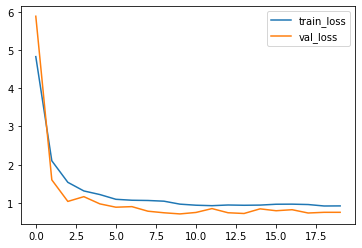

In [21]:
_ = log.plot()

We can get the partial log-likelihood

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

#### Evaluation for DSAFT model

To exploit evaluation metrics provided by PyCox, survival function on durations (especially from training dataset) must be estimated. For this, Kaplan-Meier estimator is used, and estimated residuals are used as duration dataset.

In [30]:
# ! pip install lifelines

In [23]:
import warnings
from lifelines import KaplanMeierFitter

def get_surv(model, input):
    '''
    model: PyCox model class or compatibles
    input: covariate dataset to compute survival estimates
    '''
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    input, target = model.training_data

    y, d = target
    df = pd.DataFrame(y, d)
    df.columns = ["y"]
    df = df.sort_values(by = ["y"])
    
    y_sorted = df.values.reshape(-1)
    d_sorted = np.array(df.index, dtype = np.float32)
    
    theta_test = model.predict(x_test)

    e = (np.repeat(y_sorted.reshape(-1, 1), theta_test.shape[0], axis = 1) - np.exp(theta_test.reshape(-1)))
    
    surv_ = KaplanMeierFitter().fit(e.reshape(-1), np.array(list(d_sorted) * theta_test.shape[0])).survival_function_at_times(e.reshape(-1))
    surv = pd.DataFrame(surv_.to_numpy().reshape(-1, theta_test.shape[0]))
    surv.index = y_sorted
    surv.index.names = ["duration"]
    
    return surv

In [24]:
surv = get_surv(model, x_test)

In [25]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [26]:
ev.concordance_td()

0.6354784709272758

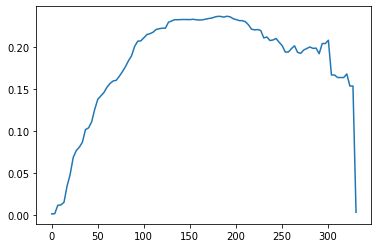

In [27]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [28]:
ev.integrated_brier_score(time_grid)

0.1826373390942702

In [29]:
ev.integrated_nbll(time_grid)

0.5455059901223349